## 0 Импорты + Загрузка данных 

In [ ]:
import pandas as pd
import polars as pl
import numpy as np
import typing as t
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from tqdm.notebook import tqdm
from IPython.display import HTML
from dataclasses import dataclass
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import warnings
warnings.simplefilter("ignore")



In [2]:
data_folder = "/home/gleb_galagan/tbank_recsys/sirius_recsys/sirius-2025-recsys/data/"
train = pl.read_parquet(data_folder + "train.pq")
books = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')
# books_descr = pl.read_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_title_description_emb.parquet')
test_exploded = pl.read_parquet(data_folder + "test.pq")
test = test_exploded.group_by("user_id", maintain_order=True).agg(pl.col("item_id"))

In [3]:
# ===========================================================================================
# Здесь закомменчен препроцессинг над books который я потом сохранил в books_all_embs.parquet
# ===========================================================================================


# ============
# join полученных эмбеддингов
# ============
# books = books.join(
#     books_descr.select(['item_id', 'description_embeddings']),
#     on='item_id',
#     how='left'  # Keep all rows from books, even if no match in books_emb
# )

# ================
# Используем эмбеддинги тегов взятые мешком слов
# ================
# tags_as_strings = books["tags"].map_elements(lambda x: " ".join(x), return_dtype=pl.String)

# vectorizer = CountVectorizer(min_df=0.2, max_df=0.8, max_features=32)
# X = vectorizer.fit_transform(tags_as_strings)
# embeddings = normalize(X.toarray()).tolist()

# books = books.with_columns(
#     pl.Series("embedding_tags", embeddings)
# )

# ============
# Приводим эмбеддинги картинок к одному размеру
# ============
# def standardize_embedding(embedding, target_dim=1024):
#     if embedding is None:  # Handle null values
#         return [0.0] * target_dim
#     embedding = np.array(embedding, dtype=np.float32)
#     if len(embedding) == target_dim:
#         return embedding.tolist()
#     elif len(embedding) < target_dim:
#         # Pad with zeros
#         return np.pad(embedding, (0, target_dim - len(embedding)), mode='constant').tolist()
#     else:
#         # Truncate to target dimension
#         return embedding[:target_dim].tolist()


# books = books.with_columns(
#     pl.col('image_embedding').map_elements(
#         lambda x: standardize_embedding(x, target_dim=1024),
#         return_dtype=pl.List(pl.Float32)
#     )
# )
# books.write_parquet('/home/gleb_galagan/tbank_recsys/baseline_solution/books_all_embs.parquet')


In [4]:
n_books = books.shape[0]
print(f"N books: {n_books}")

n_cold_books = n_books - train["item_id"].n_unique()
print(f"N 'cold' books: {n_cold_books}")

N books: 34322
N 'cold' books: 3022


## Класс для валидации

In [5]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth") -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog


def evaluate_recommender(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
) -> dict:
    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]
    result = {}
    
    # Create a copy to avoid modifying the original dataframe
    result_df = df.clone()
    
    for metric in metrics:
        result_df = result_df.with_columns(
            metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
        )
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)
    
    return result

NOTE: Сказали не трогать класс выше, не трогаю

In [6]:
# evaluation по сплиту холодных и теплых айтемов

def evaluate_with_cold_split(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = None,
    n_items_in_catalog: int = None,
    k: int = 10,
) -> dict:
    metrics = [NDCG(k=k), Recall(k=k)]
    result = {}

    # помечаем, есть ли в ground_truth холодные айтемы
    df = df.with_columns(
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.any()
        .alias("has_cold")
    )

    # считаем по сплитам
    for split_name, mask in [("cold", pl.col("has_cold")),
                             ("warm", ~pl.col("has_cold"))]:
        split_df = df.filter(mask)
        if split_df.height == 0:
            continue

        for metric in metrics:
            split_df = split_df.with_columns(
                metric(preds_col=model_preds_col, ground_truth_col=ground_truth_col)
            )
            result[f"{metric.full_name}_{split_name}"] = round(
                split_df.select(pl.col(metric.full_name).mean()).item(), 3
            )

        if n_items_in_catalog is not None:
            result[f"coverage_{split_name}"] = round(
                coverage(split_df, n_items_in_catalog, preds_col=model_preds_col), 3
            )

    return result

In [7]:
all_books = set(books['item_id']) 
train_books = set(train['item_id'])
cold_books = all_books - train_books
hot_books = all_books & train_books


# hot_set = 
print(f'Hot books {len(hot_books)}\n\nCold books {len(cold_books)}')

Hot books 31300

Cold books 3022


## Новые метрики
Как говорилось выше не стал трогать класс как говорилось. Добавил метрику **Serendipity** и **ARP**

$$Serendipity@k = (\sum_{i=1}^{k} max(p(i) - pu(i), 0) * rel(i)) / k$$

Логика добавления Serendipity в том чтобы измерить эффект удивления от добавления холодных айтемов 

$$ARP@k = \frac{1}{|U_{t}|}\sum_{u\in U_{t}^{}}\frac{\sum_{i\in L_{u}}\phi (i)}{|L_{u}|}$$

ARP (Average Recommendations Popularity) - у нас показывает среднюю популярность рекомендуемых айтемов в списке. Логика в том чтоб измерить  то какой у нас байес на популярное в рекомендациях. И как на это будут влиять холодные айтемы. Важный момент в ARP, цель скорее ее минимизировать, тк популярные айтемы для всех это не лучшая идея


In [8]:
# ACHTUNG! DO NOT TOUCH

@dataclass
class AtKMetric(ABC):
    k: int

    @property
    @abstractmethod
    def name(self) -> str:
        raise NotImplementedError

    @property
    def full_name(self) -> str:
        return f"{self.name}@{self.k}"

    @abstractmethod
    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        raise NotImplementedError


class NDCG(AtKMetric):
    @property
    def name(self) -> str:
        return "ndcg"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def _dcg(scores: np.ndarray) -> float:
            # Handle empty arrays
            if len(scores) == 0:
                return 0.0
            # Use vectorized operations for better performance
            positions = np.arange(1, len(scores) + 1, dtype=np.float64)
            return np.sum((np.power(2, scores) - 1) / np.log2(positions + 1))

        def ndcg(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty predictions or ground truth
            if not predicted or not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Create relevance scores (1 for relevant items, 0 otherwise)
            relevance = np.array([1 if x in gt_items else 0 for x in predicted], dtype=np.float64)
            
            rank_dcg = _dcg(relevance)
            if rank_dcg == 0.0:
                return 0.0
                
            # Ideal DCG: sort ground truth by relevance (all 1s) and take top-k
            ideal_relevance = np.ones(min(len(gt_items), self.k), dtype=np.float64)
            ideal_dcg = _dcg(ideal_relevance)
            
            if ideal_dcg == 0.0:
                return 0.0
                
            return rank_dcg / ideal_dcg

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: ndcg(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)


class Recall(AtKMetric):
    @property
    def name(self) -> str:
        return "recall"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", **kwargs) -> pl.Expr:
        def recall(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            # Handle empty ground truth
            if not gt_items:
                return 0.0
                
            # Take only top-k predictions
            predicted = predicted[:self.k]
            
            # Calculate intersection
            intersection = len(set(gt_items).intersection(set(predicted)))
            return intersection / len(gt_items)

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: recall(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)

# ==================
# Новая метрика ARP
# ==================
class ARP(AtKMetric):
    """
    Calculates the Average Recommendation Popularity (ARP).
    This metric measures the average popularity of the recommended items.
    A lower ARP suggests the model is recommending less obvious, "long-tail" items.
    """
    @property
    def name(self) -> str:
        return "arp"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for ARP metric")

        def arp(predicted: list[t.Any]) -> float:
            if not predicted:
                return 0.0
            
            predicted = predicted[:self.k]
            
            # Get popularities, default to 0 if item not in map
            popularities = [item_popularity_map.get(item, 0.0) for item in predicted]
            
            if not popularities:
                return 0.0
                
            return sum(popularities) / len(popularities)

        # Note: ground_truth_col is not used but is part of the abstract method signature.
        return pl.col(preds_col).map_elements(
            lambda p: arp(p),
            return_dtype=pl.Float64
        ).alias(self.full_name)
        
# ==============
# Новая метрика Serndipity
# ==============
class Serendipity(AtKMetric):
    """
    Calculates Serendipity.
    This metric rewards recommendations that are both relevant (in ground truth)
    and surprising (unpopular). The score for a user is the sum of (1 - popularity)
    for each correctly recommended item.
    """
    @property
    def name(self) -> str:
        return "serendipity"

    def __call__(self, *, preds_col: str = "preds", ground_truth_col: str = "ground_truth", item_popularity_map: dict[t.Any, float] | None = None, **kwargs) -> pl.Expr:
        if item_popularity_map is None:
            raise ValueError("item_popularity_map is required for Serendipity metric")

        def serendipity(predicted: list[t.Any], gt_items: list[t.Any]) -> float:
            if not predicted or not gt_items:
                return 0.0
                
            predicted = predicted[:self.k]
            
            # Find relevant recommended items
            relevant_preds = set(predicted).intersection(set(gt_items))
            
            if not relevant_preds:
                return 0.0
                
            # Score is the sum of (1 - popularity) for each relevant item
            score = sum(1 - item_popularity_map.get(item, 0.0) for item in relevant_preds)
            
            # Normalize by k to get an average serendipity score per recommendation slot
            return score / self.k

        return pl.struct([preds_col, ground_truth_col]).map_elements(
            lambda x: serendipity(x[preds_col], x[ground_truth_col]),
            return_dtype=pl.Float64
        ).alias(self.full_name)



def coverage(df: pl.DataFrame, n_items_in_catalog: int, preds_col: str = "preds") -> float:
    if n_items_in_catalog <= 0:
        return 0.0
        
    unique_recommended = df.select(
        pl.col(preds_col).explode().n_unique()
    ).item()
    return unique_recommended / n_items_in_catalog



def evaluate_extended(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    n_items_in_catalog: int = n_books,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Расширенная функция расчета метрик. Здесь добавлены ARP и Serendipity. Для расчета этих метрик считаем матрицу популярности. 
    """
    # Compute item_popularity_map from train_df
    if train_df is not None:
        total_interactions = train_df.height
        item_counts = (
            train_df
            .group_by("item_id")
            .agg(pl.count().alias("count"))
        )
    
    # Normalize by maximum count to get 0-1 range
        max_count = item_counts.select(pl.col("count").max()).item()
    
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
    else:
        item_popularity_map = None

    metrics = [
        NDCG(k=k),
        Recall(k=k),
    ]

    if item_popularity_map:
        metrics.extend([
            ARP(k=k),
            Serendipity(k=k),
        ])

    result = {}
    result_df = df.clone()

    for metric in metrics:
        metric_kwargs = {
            "preds_col": model_preds_col,
            "ground_truth_col": ground_truth_col,
        }
        if isinstance(metric, (ARP, Serendipity)):
            if not item_popularity_map:
                print(f"Skipping {metric.name} because item_popularity_map is not provided.")
                continue
            metric_kwargs["item_popularity_map"] = item_popularity_map

        # Calculate metric
        result_df = result_df.with_columns(
            metric(**metric_kwargs)
        )
        
        result[metric.full_name] = round(result_df.select(pl.col(metric.full_name).mean()).item(), 3)

    if n_items_in_catalog is not None:
        result["coverage"] = round(coverage(result_df, n_items_in_catalog, preds_col=model_preds_col), 3)

    return result


In [32]:
def evaluate_cold_item_performance(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = train,
    k: int = 10,
) -> dict:
    """
    Evaluates model performance specifically on cold vs warm items.
    For each user, splits their ground truth into cold/warm and measures
    how many cold items vs warm items the model successfully recommends.
    """
    
    def split_ground_truth_and_calculate_metrics(predicted: list, gt_items: list) -> dict:
        if not predicted or not gt_items:
            return {"cold_hits": 0, "warm_hits": 0, "total_cold_gt": 0, "total_warm_gt": 0}
        
        predicted_top_k = predicted[:k]
        predicted_set = set(predicted_top_k)
        
        # Split ground truth into cold and warm
        cold_gt = [item for item in gt_items if item in cold_items]
        warm_gt = [item for item in gt_items if item not in cold_items]
        
        # Count hits for each type
        cold_hits = len([item for item in cold_gt if item in predicted_set])
        warm_hits = len([item for item in warm_gt if item in predicted_set])
        
        return {
            "cold_hits": cold_hits,
            "warm_hits": warm_hits,
            "total_cold_gt": len(cold_gt),
            "total_warm_gt": len(warm_gt)
        }
    
    # Apply the function to each row
    results = []
    for row in df.iter_rows(named=True):
        predicted = row[model_preds_col]
        gt_items = row[ground_truth_col]
        results.append(split_ground_truth_and_calculate_metrics(predicted, gt_items))
    
    # Aggregate results
    total_cold_hits = sum(r["cold_hits"] for r in results)
    total_warm_hits = sum(r["warm_hits"] for r in results)
    total_cold_gt = sum(r["total_cold_gt"] for r in results)
    total_warm_gt = sum(r["total_warm_gt"] for r in results)
    
    metrics = {}
    
    # Cold item recall
    if total_cold_gt > 0:
        metrics["cold_item_recall"] = round(total_cold_hits / total_cold_gt, 3)
    else:
        metrics["cold_item_recall"] = 0.0
    
    # Warm item recall  
    if total_warm_gt > 0:
        metrics["warm_item_recall"] = round(total_warm_hits / total_warm_gt, 3)
    else:
        metrics["warm_item_recall"] = 0.0
    
    # Additional statistics
    metrics["total_cold_items_in_gt"] = total_cold_gt
    metrics["total_warm_items_in_gt"] = total_warm_gt
    metrics["cold_items_recommended"] = total_cold_hits
    metrics["warm_items_recommended"] = total_warm_hits
    
    return metrics


def evaluate_by_user_types(
    df: pl.DataFrame,
    model_preds_col: str,
    ground_truth_col: str = "item_id",
    cold_items: set[int] = None,
    k: int = 10,
    train_df: pl.DataFrame | None = train,
) -> dict:
    """
    Evaluates performance by user types:
    - pure_cold: users who have ONLY cold items in ground truth
    - mixed: users who have both cold and warm items
    - pure_warm: users who have ONLY warm items in ground truth
    """
    
    # Classify users
    df = df.with_columns([
        # Count cold items in ground truth
        pl.col(ground_truth_col)
        .list.eval(pl.element().is_in(cold_items))
        .list.sum()
        .alias("cold_count"),
        
        # Total items in ground truth
        pl.col(ground_truth_col).list.len().alias("total_count")
    ]).with_columns([
        # Classify user types
        pl.when(pl.col("cold_count") == pl.col("total_count"))
        .then(pl.lit("pure_cold"))
        .when(pl.col("cold_count") == 0)
        .then(pl.lit("pure_warm"))  
        .otherwise(pl.lit("mixed"))
        .alias("user_type")
    ])
    
    metrics = [NDCG(k=k), Recall(k=k)]
    result = {}
    
    # Add popularity-based metrics if train_df is available
    if train_df is not None:
        item_counts = train_df.group_by("item_id").agg(pl.count().alias("count"))
        max_count = item_counts.select(pl.col("count").max()).item()
        item_popularity_map = dict(
            item_counts
            .with_columns((pl.col("count") / max_count).alias("popularity"))
            .select(["item_id", "popularity"])
            .iter_rows()
        )
        metrics.extend([ARP(k=k), Serendipity(k=k)])
    else:
        item_popularity_map = None
    
    # Evaluate each user type
    for user_type in ["pure_cold", "mixed", "pure_warm"]:
        type_df = df.filter(pl.col("user_type") == user_type)
        
        if type_df.height == 0:
            continue
            
        
        for metric in metrics:
            metric_kwargs = {
                "preds_col": model_preds_col,
                "ground_truth_col": ground_truth_col,
            }
            
            if isinstance(metric, (ARP, Serendipity)) and item_popularity_map:
                metric_kwargs["item_popularity_map"] = item_popularity_map
            
            type_df = type_df.with_columns(metric(**metric_kwargs))
            result[f"{metric.full_name}_{user_type}"] = round(
                type_df.select(pl.col(metric.full_name).mean()).item(), 3
            )
    
    return result

### Для проверки новых метрик давайте возьмем TopPopular класс из бейзлайна



In [33]:
class TopPopular:
    def __init__(self):
        self.trained = False
        self.recommendations = None

    def fit(self, df: pl.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = (
            df.lazy()
            .group_by(item_id_col)
            .agg(count=pl.len())
            .sort("count", descending=True)
            .collect()
            [item_id_col]
            .to_numpy()
        )
        self.trained = True

    def predict(self, df: pl.DataFrame, topn: int = 10) -> list[np.ndarray]:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train)
test = test.with_columns(
    toppopular_recs=pl.Series(toppop.predict(test))
)
print(test.head())
print('Perfomance on cold and warm\n')
print(evaluate_cold_item_performance(df=test, model_preds_col="toppopular_recs"))
print('\nPerfomance on users with cold and warm\n')
print(evaluate_by_user_types(df=test, model_preds_col="toppopular_recs", cold_items=cold_books))
print('\nExtended metrics\n')
print(evaluate_extended(df=test, model_preds_col="toppopular_recs", n_items_in_catalog=n_books))

shape: (5, 5)
┌───────────────────┬───────────────────┬───────────────────┬───────────────────┬──────────────────┐
│ user_id           ┆ item_id           ┆ toppopular_recs   ┆ bandit_recs       ┆ bandit_recs_load │
│ ---               ┆ ---               ┆ ---               ┆ ---               ┆ ed               │
│ str               ┆ list[i64]         ┆ array[i64, 10]    ┆ array[i64, 10]    ┆ ---              │
│                   ┆                   ┆                   ┆                   ┆ array[i64, 10]   │
╞═══════════════════╪═══════════════════╪═══════════════════╪═══════════════════╪══════════════════╡
│ 00000377eea48021d ┆ [13252]           ┆ [4058, 15514, …   ┆ [22638, 18154, …  ┆ [22893, 3706, …  │
│ 3002730d56aca…    ┆                   ┆ 13159]            ┆ 27189]            ┆ 20531]           │
│ 00009ab2ed8cbfced ┆ [2328]            ┆ [4058, 15514, …   ┆ [16707, 22584, …  ┆ [1412, 20807, …  │
│ a5a59da409663…    ┆                   ┆ 13159]            ┆ 9755]          

Как видим у нас очень высокий ARP и достаточно низкий Serendipity, так что есть смысл сравнивать алгоритмы не только по Recall и NDCG но и по новым добавленным метрикам которые также отражают впечатление юзеров о реальном сервисе 

## Multiarmed Bandits greedy

In [ ]:

import polars as pl
import numpy as np
from scipy.cluster.vq import kmeans2
from abc import ABC, abstractmethod
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pl.DataFrame, **kwargs) -> None:
        self.trained = True

    @abstractmethod
    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        pass

class BanditRecommender(BaseRecommender):
    def __init__(self, n_clusters=20, epsilon=0.2):  
        super().__init__()
        self.n_clusters = n_clusters
        self.epsilon = epsilon
        self.item_ids = None
        self.clusters = None
        self.bandits = {}
        self.books_df = None
        self.cluster_items = {}  # Pre-computed items per cluster for efficiency

    class EpsilonGreedyBandit:
        def __init__(self, n_arms, epsilon):
            self.n_arms = n_arms
            self.epsilon = epsilon
            self.counts = np.zeros(n_arms)
            self.values = np.zeros(n_arms)
            
        def select_arm(self):
            # выбираем случайную ручку исходя из того меньше ли вероятность чем эпсилон
            if np.random.rand() < self.epsilon:
                return np.random.randint(0, self.n_arms)
            return np.argmax(self.values)
        
        def update(self, arm, reward):
            self.counts[arm] += 1
            n = self.counts[arm]
            value = self.values[arm]
            # обновляем значение ручки, усредняем
            self.values[arm] = ((n - 1) / n) * value + (1 / n) * reward

    def fit(self, df: pl.DataFrame, items_df: pl.DataFrame, item_id_col: str = "item_id", **kwargs) -> None:
        """
        Создаем кластера из нормированных эмбеддингов
        """
        self.books_df = items_df.clone()
        self.item_ids = items_df[item_id_col].to_numpy()

        try:
            title_emb = np.stack(items_df['title_embeddings'].to_list())
            desc_emb = np.stack(items_df['description_embeddings'].to_list())
            
            # Check if additional embeddings exist
            embeddings_list = [title_emb, desc_emb]
            
            if 'image_embedding' in items_df.columns:
                image_emb = np.stack(items_df['image_embedding'].to_list())
                embeddings_list.append(image_emb)
            
            if 'embedding_tags' in items_df.columns:
                tags_emb = np.stack(items_df['embedding_tags'].to_list())
                embeddings_list.append(tags_emb)
            
            # Конкатенируем все эмбеддинги
            embeddings = np.concatenate(embeddings_list, axis=1)
            
            # Нормируем эмбеддинги
            embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)
            
        except Exception as e:
            print(f"Error processing embeddings: {e}")
            # Fallback: только title embeddings
            embeddings = np.stack(items_df['title_embeddings'].to_list())
            embeddings = embeddings / (np.linalg.norm(embeddings, axis=1, keepdims=True) + 1e-8)

        # Improved clustering with error handling
        try:
            # Ensure we don't have more clusters than items
            n_clusters = min(self.n_clusters, len(embeddings) // 2)
            _, labels = kmeans2(embeddings, k=n_clusters, minit='points', iter=50)
            self.clusters = labels
        except Exception as e:
            print(f"Clustering failed: {e}, using random assignment")
            self.clusters = np.random.randint(0, self.n_clusters, size=len(embeddings))

        # Предварительно рассчитываем кластеры по 
        self.books_df = self.books_df.with_columns(pl.Series('cluster', self.clusters, dtype=pl.Int32))
        
        for cluster_id in range(self.n_clusters):
            cluster_books = self.books_df.filter(pl.col('cluster') == cluster_id)
            if len(cluster_books) > 0:
                # Sort by description length as popularity proxy
                cluster_books = cluster_books.with_columns(
                    pl.col('description').str.len_bytes().alias('desc_len')
                ).sort('desc_len', descending=True)
                self.cluster_items[cluster_id] = cluster_books[item_id_col].to_numpy()
            else:
                self.cluster_items[cluster_id] = np.array([])

        # Initialize bandits for existing users
        for user_id in df['user_id'].unique():
            self.bandits[user_id] = self.EpsilonGreedyBandit(n_arms=self.n_clusters, epsilon=self.epsilon)

        self.trained = True

    def _recommend_books(self, cluster: int, topn: int = 10) -> np.ndarray:
        """Efficient book recommendation from pre-computed cluster items"""
        if cluster in self.cluster_items and len(self.cluster_items[cluster]) > 0:
            cluster_books = self.cluster_items[cluster]
            return cluster_books[:min(topn, len(cluster_books))]
        else:
            # Fallback to random selection from all items
            return np.random.choice(self.item_ids, size=min(topn, len(self.item_ids)), replace=False)

    def predict(self, df: pl.DataFrame, topn: int = 10, **kwargs) -> list[np.ndarray]:
        assert self.trained, "Model must be trained before prediction"

        predictions = []
        unique_users = df['user_id'].unique().to_list()
        
        for user_id in tqdm(unique_users, desc="Generating recommendations"):
            # Получаем или создаем бандита для юзера
            if user_id not in self.bandits:
                self.bandits[user_id] = self.EpsilonGreedyBandit(n_arms=self.n_clusters, epsilon=self.epsilon)
            
            # Выбираем кластер с помощью бандита
            cluster = self.bandits[user_id].select_arm()
            
            # Get recommendations from cluster
            recommended_items = self._recommend_books(cluster, topn)
            
            # Убеждаеся то что у нас достаточно рекомендаций
            if len(recommended_items) < topn:
                remaining = topn - len(recommended_items)
                # Убираем уже рекомендованные айтемы
                available_items = np.setdiff1d(self.item_ids, recommended_items)
                if len(available_items) > 0:
                    additional = np.random.choice(
                        available_items, 
                        size=min(remaining, len(available_items)), 
                        replace=False
                    )
                    recommended_items = np.concatenate([recommended_items, additional])
            
            predictions.append(recommended_items[:topn])
            
            # Simulate higher reward for popular clusters
            cluster_size = len(self.cluster_items.get(cluster, []))
            reward_prob = min(0.8, 0.1 + (cluster_size / len(self.item_ids)) * 2)
            reward = np.random.choice([0, 1], p=[1-reward_prob, reward_prob])
            self.bandits[user_id].update(cluster, reward)

        return predictions


In [ ]:
import numpy as np
np.random.seed(2025)
# Инициализация
bandit_rec = BanditRecommender(n_clusters=50, epsilon=0.60)

bandit_rec.fit(train, books)

# Предсказания
test = test.with_columns(
    bandit_recs=pl.Series(bandit_rec.predict(test, topn=10))
)

# Вывод первых строк
print(test.head())

res = evaluate_recommender(df=test, model_preds_col="bandit_recs")
print(res)


Generating recommendations: 100%|██████████| 185828/185828 [00:09<00:00, 18997.82it/s]


shape: (5, 4)
┌────────────────────────┬───────────────────────┬────────────────────────┬────────────────────────┐
│ user_id                ┆ item_id               ┆ toppopular_recs        ┆ bandit_recs            │
│ ---                    ┆ ---                   ┆ ---                    ┆ ---                    │
│ str                    ┆ list[i64]             ┆ array[i64, 10]         ┆ array[i64, 10]         │
╞════════════════════════╪═══════════════════════╪════════════════════════╪════════════════════════╡
│ 00000377eea48021d30027 ┆ [13252]               ┆ [4058, 15514, … 13159] ┆ [22638, 18154, …       │
│ 30d56aca…              ┆                       ┆                        ┆ 27189]                 │
│ 00009ab2ed8cbfceda5a59 ┆ [2328]                ┆ [4058, 15514, … 13159] ┆ [16707, 22584, … 9755] │
│ da409663…              ┆                       ┆                        ┆                        │
│ 00009e46d18f223a82b22d ┆ [28636, 30197]        ┆ [4058, 15514, … 13159] ┆ [

#### Загружаем модель и проверяем работоспособность

In [ ]:
import joblib
np.random.seed(2025)
bandit_rec = BanditRecommender(n_clusters=50, epsilon=0.60)
# bandit_rec.fit(train, books)
model_filename = "models/bandit_recommender_v1.joblib"

# joblib.dump(bandit_rec, model_filename)
# print(f" Model has been saved to '{model_filename}'")


loaded_bandit_rec = joblib.load(model_filename)

test = test.with_columns(
    bandit_recs_loaded=pl.Series(loaded_bandit_rec.predict(test, topn=10))
)


resss = evaluate_recommender(df=test, model_preds_col="bandit_recs_loaded")
print("\nEvaluation results from loaded model:")
print(resss)

Generating recommendations: 100%|██████████| 185828/185828 [00:09<00:00, 19485.40it/s]



Evaluation results from loaded model:
{'ndcg@10': 0.004, 'recall@10': 0.003, 'coverage': 0.854}


#### Тестируем как работают наши функции оценки метрик (напомню добавлены ARP Serendipity и оценка сплитов cold hot)

In [28]:
ext_eval = evaluate_extended(
    df=test,
    model_preds_col="bandit_recs",
    n_items_in_catalog=books['item_id'].n_unique(),
    k=10,
    train_df=train  # Must have "item_id" column
)
bandit_overall_pd = pd.DataFrame({"greedy_mab_ov": ext_eval})
bandit_overall_pd.index.name = "metric"
bandit_overall_pd.to_csv('results_csv/greedy_mab_ov.csv', index=True)
bandit_overall_pd

,greedy_mab_ov
metric,
ndcg@10,0.003
recall@10,0.003
arp@10,0.035
serendipity@10,0.002
coverage,0.854


In [ ]:
mab_perf = evaluate_cold_item_performance(
    df=test,
    model_preds_col="bandit_recs",
    cold_items=cold_books,
)
bandit_perf_pd = pd.DataFrame({"greedy_mab_perf": mab_perf})
bandit_perf_pd.index.name = "metric"

bandit_perf_pd.to_csv('results_csv/greedy_mab_perf.csv', index=True)
bandit_perf_pd

,greedy_mab_perf
metric,
cold_item_recall,0.000
warm_item_recall,0.002
total_cold_items_in_gt,187372.000
total_warm_items_in_gt,2947221.000
cold_items_recommended,29.000
warm_items_recommended,5358.000


In [ ]:
ext_split = evaluate_by_user_types(
    df=test,
    model_preds_col="bandit_recs",
    cold_items=cold_books,
)
bandit_split_pd = pd.DataFrame({"greedy_mab_split": ext_split})
bandit_split_pd.index.name = "metric"
bandit_split_pd.to_csv('results_csv/greedy_mab_split.csv', index=True)

bandit_split_pd


pure_cold: 1703 users

mixed: 44793 users

pure_warm: 139332 users


,greedy_mab_split
metric,
ndcg@10_pure_cold,0.000
recall@10_pure_cold,0.000
arp@10_pure_cold,0.034
serendipity@10_pure_cold,0.000
ndcg@10_mixed,0.006
recall@10_mixed,0.002
arp@10_mixed,0.035
serendipity@10_mixed,0.005
ndcg@10_pure_warm,0.003


## Вывод по MAB Greedy

Метрики выше случайного (кроме coverage), для сравнения 'ndcg@10': 0.001, 'recall@10': 0.0, 'coverage': 1.0 в Random. В данном алгоритме очень много зависит от random.seed и параметров. Лучшие (если можно так сказать скоры) выбивались на 50 кластерах и epsilon 0.6 а также хороший скор был 20 кластеров 0.45 epsilon


Популярное в greedy MAB тоже присутствует arp 0.35 (из за того что мы экспуатируем самую удачную ручку, а там скорее больше популярных), в отличие от TopPopular у нас все таки есть рекомендации из холодных айтемов, но теплых само собой сильно больше. Также у этого алгоритма несравнимо выше coverage: 0.854 

In [20]:
test['bandit_recs_loaded']

bandit_recs_loaded
"array[i64, 10]"
"[22893, 3706, … 20531]"
"[1412, 20807, … 32507]"
"[13, 16, … 262]"
"[13, 16, … 262]"
"[12790, 4699, … 17137]"
…
"[34177, 5450, … 34079]"
"[2733, 18284, … 15610]"
"[15901, 15520, … 27029]"


## EDA по рекомендованым товарам


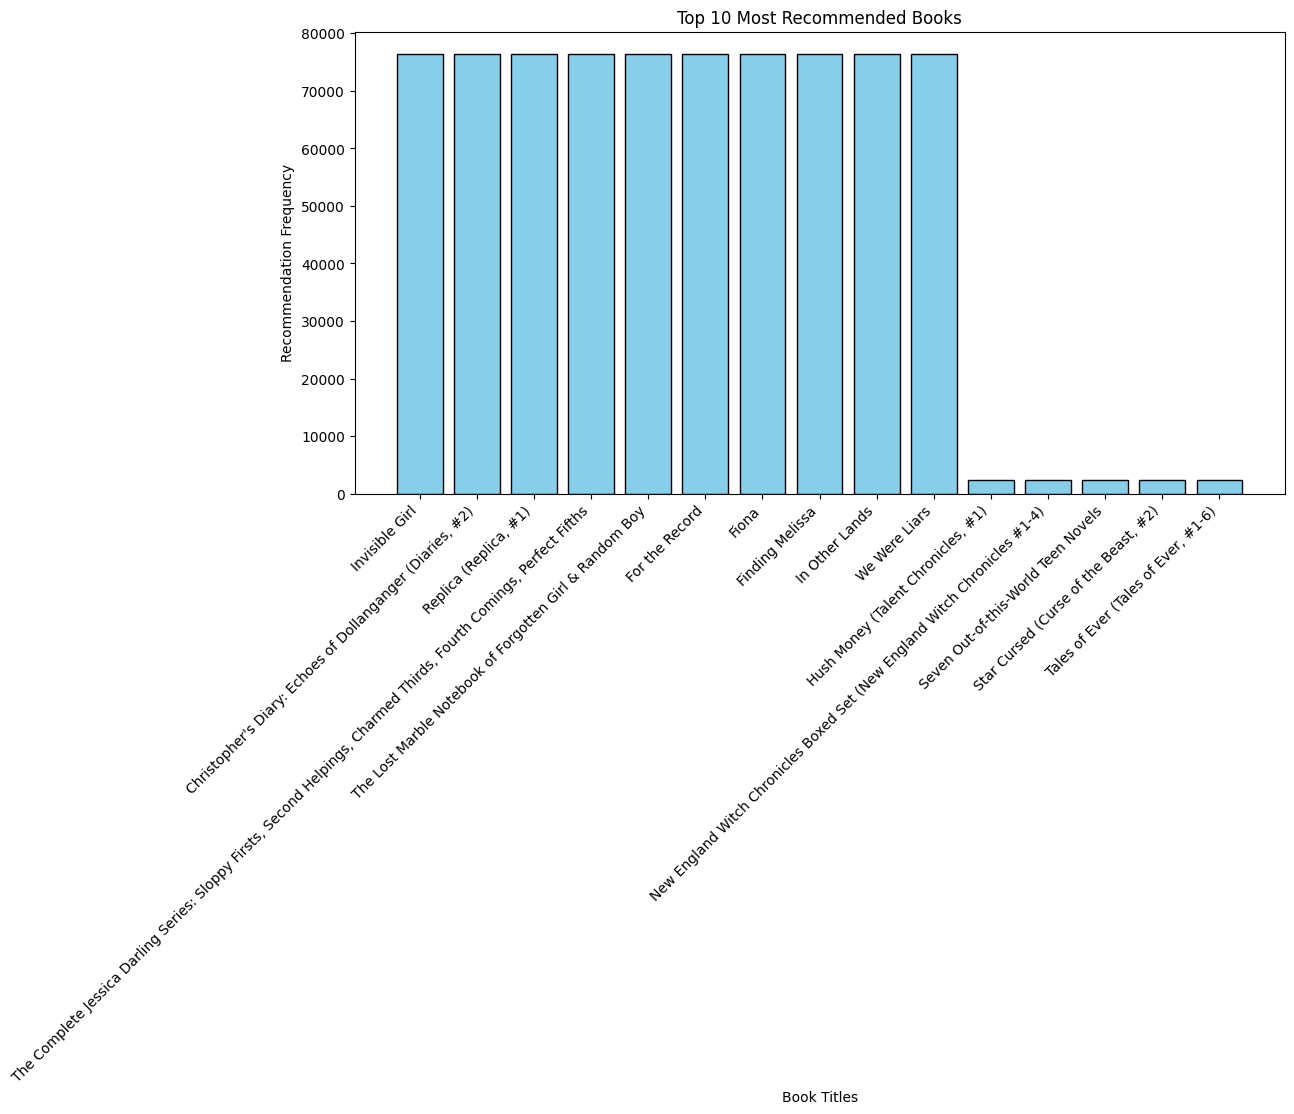

In [21]:

flat_recs = test['bandit_recs_loaded'].to_numpy().flatten()
recs_df = pl.DataFrame({"item_id": flat_recs})

freq_df = recs_df.group_by("item_id").agg(count=pl.col("item_id").count()).sort("count", descending=True)



top_10_df = freq_df.head(15).join(books.select(["item_id", "title"]), on="item_id", how="left")
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()


plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("Recommendation Frequency")
plt.title("Top 10 Most Recommended Books")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Как можно видеть на гистограмме есть топ 10 айтемов (рандомных) которые рекомендуются по 7 тысяч раз, далее идет провал и следующие айтемы рекомендуются уже менее чем 600 раз.

Поскольку алгоритм рандомный то особой логики  искать не стоит, как видно в топе есть серийные книги, причем серия не 1я (логики в том что мы рекомендуем юзеру не читавшему 1ю часть книги (например Elske или the King of Attolia, The Broken Sun) сразу 3ю или 4ю часть тоже особо нет) 

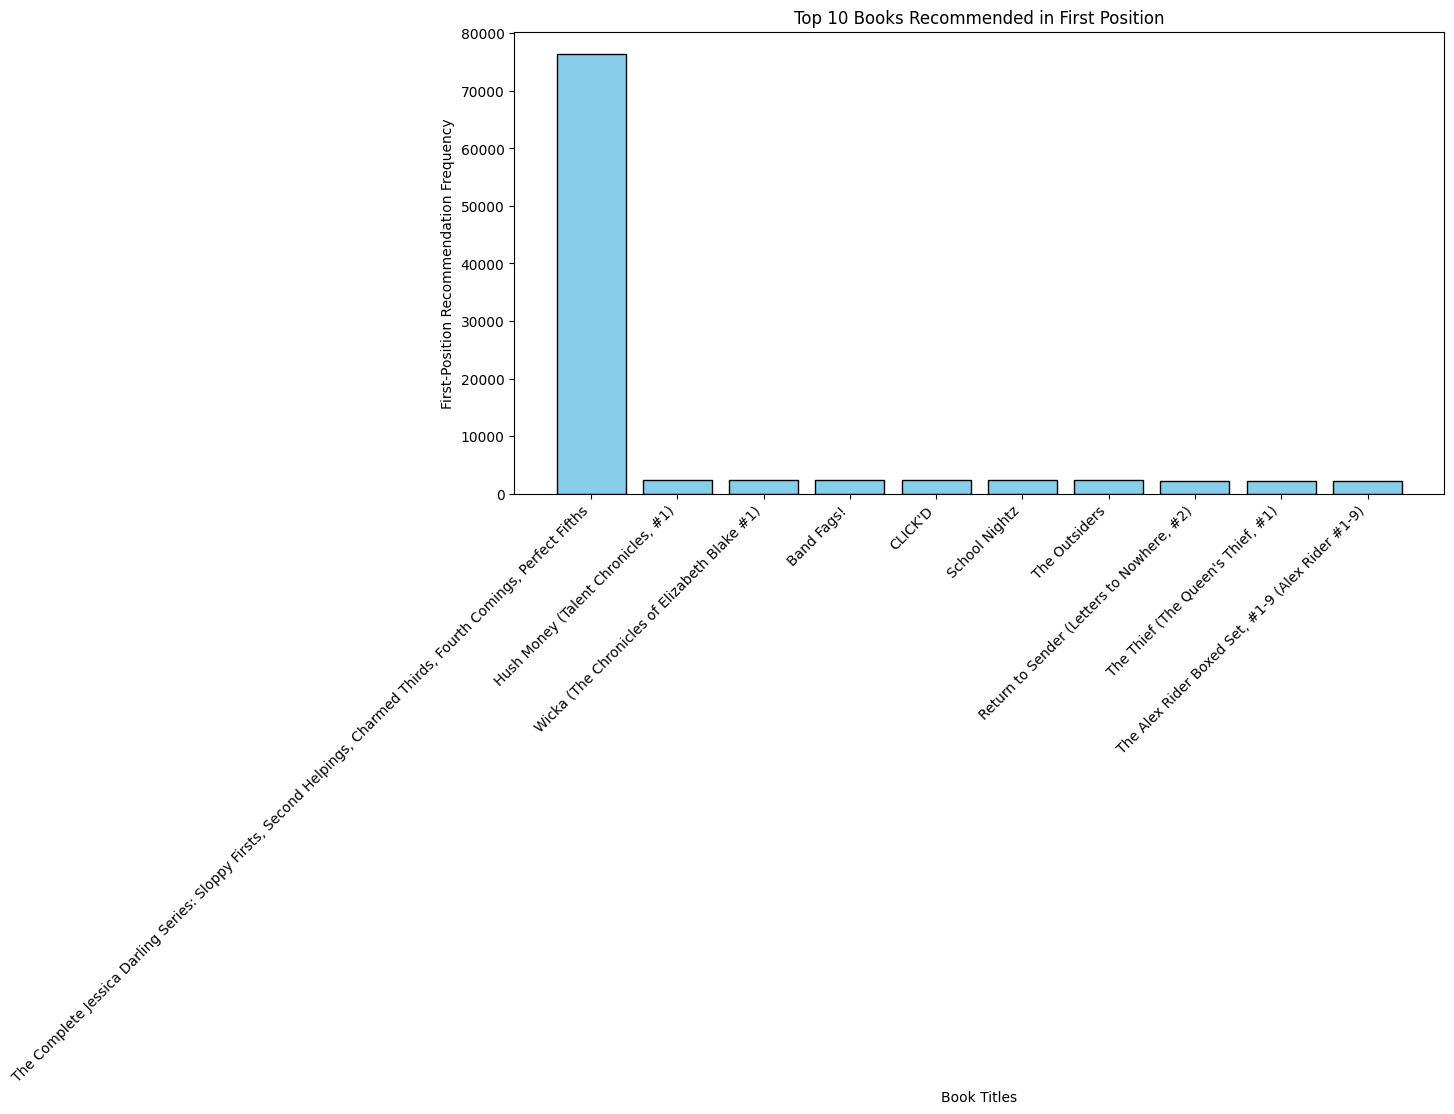

In [22]:
first_position_recs = test['bandit_recs_loaded'].to_numpy()[:, 0]

# Create Polars DataFrame for first-position recommendations
recs_df = pl.DataFrame({"item_id": first_position_recs})

# Count frequency of each item_id in first position
freq_df = recs_df.group_by("item_id").agg(count=pl.col("item_id").count()).sort("count", descending=True)

# Load Books DataFrame (assuming it's already in Polars format)
# Replace with your actual Books DataFrame


# Get top 10 most frequent first-position items and join with Books to get titles
top_10_df = freq_df.head(10).join(books.select(["item_id", "title"]), on="item_id", how="left")

# Handle missing titles by replacing nulls with "Unknown Title"
top_10_df = top_10_df.with_columns(pl.col("title").fill_null("Unknown Title"))

# Prepare data for plotting
titles = top_10_df["title"].to_list()
counts = top_10_df["count"].to_list()

# Create histogram using Matplotlib with same style as previous
plt.figure(figsize=(12, 6))
plt.bar(titles, counts, color="skyblue", edgecolor="black")
plt.xlabel("Book Titles")
plt.ylabel("First-Position Recommendation Frequency")
plt.title("Top 10 Books Recommended in First Position")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Явный лидер по рекомендации на 1й позиции


#### Еще пару слов про эксперименты с алгоритмами многоруких бандитов

Из MAB алгоритмов пробовал еще Thompson Sampling и UCB, но они работают сильно более медленно и видимо жадность в Greedy дает свои плоды, алгоритм выбирает наилучшую ручку и экспуатирует ее, метрики выше, за счет exploration выше еще и Coverage